# SCADA Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('data/8 Hrs 3 Proc Normal.xlsx', sheet_name = 'Sheet1')

In [3]:
data_with_attacks = pd.read_excel('data/8 Hrs 3 Proc Normal+Attack.xlsx', 
                                  sheet_name = 'Combined Data')

## Cleaning Data

In [4]:
data.columns = ['Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201',
       'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204',
       'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'Normal/Attack']

In [5]:
data_with_attacks.columns = ['Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201',
       'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203',
       'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301',
       'MV302', 'MV303', 'MV304', 'P301', 'P302', 'Normal/Attack']

In [6]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [7]:
data_with_attacks['Timestamp'] = pd.to_datetime(data_with_attacks['Timestamp'])

In [8]:
data.head(2)

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,Normal/Attack
0,2015-12-22 16:00:00,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,20.79839,2.235275,327.4401,1,2,1,1,2,1,Normal
1,2015-12-22 16:00:01,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,20.79839,2.234507,327.4401,1,2,1,1,2,1,Normal


In [9]:
data_with_attacks.head(2)

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,Normal/Attack
0,2015-12-28 10:00:00,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,19.74838,2.206835,956.1651,1,2,1,1,1,2,Normal
1,2015-12-28 10:00:01,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,19.74838,2.208244,956.1651,1,2,1,1,1,2,Normal


## Testing for Stationarity

In [10]:
l = []
alpha = 0.05

for i in range(1,data.shape[1]-1):
    test  = sts.adfuller(data.iloc[:,i].diff(1).dropna())    
    if(test[1] < alpha):
        is_stationary = True
    else:
        is_stationary = False
        
    row = {}
    row['colname'] = data.columns[i]
    row['is_stationary'] = is_stationary
    l.append(row)

stationarity_tests = pd.DataFrame(l)

In [11]:
stationarity_tests.head(5)

,colname,is_stationary
0,FIT101,True
1,LIT101,True
2,MV101,True
3,P101,True
4,P102,False


## IQR Anomaly Detection

### Calculating range for outliers

In [12]:
def min_amt(column):
    return column.min() - 1.5*(column.quantile(0.75) - column.quantile(0.25))

def max_amt(column):
    return column.max() + 1.5*(column.quantile(0.75) - column.quantile(0.25))

In [13]:
l = []

for i in range(1, data.shape[1] - 1):
    row = {}
    row['column'] = data.columns[i]
    row['max_amt'] = data.iloc[:,i].agg(max_amt)
    row['min_amt'] = data.iloc[:,i].agg(min_amt)
    l.append(row)
    
iqr_df = pd.DataFrame(l)

In [14]:
iqr_df.head(5)

,column,max_amt,min_amt
0,FIT101,2.955513,-0.264228
1,LIT101,1486.518400,-365.894700
2,MV101,2.000000,0.000000
3,P101,2.000000,1.000000
4,P102,1.000000,1.000000


### Testing outliers on data with attacks

In [15]:
def iqr_outlier_detection(x):
    x = pd.DataFrame(x).reset_index()
    x.columns = ['column', 'value']
    iqr_x = pd.merge(x, iqr_df, on = 'column', how = 'right')
    iqr_x['Test'] = (iqr_x['value'] > iqr_x['max_amt']) | (iqr_x['value'] < iqr_x['min_amt'])
    return 'Attack' if iqr_x['Test'].any() else 'Normal'

In [16]:
data_with_attacks['iqr_result'] = data_with_attacks.apply(lambda x: iqr_outlier_detection(x), axis = 1)

In [17]:
data_with_attacks.replace(to_replace = 'Normal', value = 0, inplace = True)
data_with_attacks.replace(to_replace = 'Attack', value = 1, inplace = True)

In [18]:
confusion_matrix(y_true = data_with_attacks['Normal/Attack'], y_pred = data_with_attacks['iqr_result'])

array([[24448,    32],
       [ 2728,  1591]])

In [19]:
accuracy_score(y_true = data_with_attacks['Normal/Attack'], y_pred = data_with_attacks['iqr_result']) * 100

90.41633390048266

In [20]:
print(classification_report(y_true = data_with_attacks['Normal/Attack'], y_pred = data_with_attacks['iqr_result']))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     24480
           1       0.98      0.37      0.54      4319

    accuracy                           0.90     28799
   macro avg       0.94      0.68      0.74     28799
weighted avg       0.91      0.90      0.88     28799



In [21]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true = data_with_attacks['Normal/Attack'], 
                                  y_score = data_with_attacks['iqr_result'])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true = data_with_attacks['Normal/Attack'].ravel(), 
                                          y_score = data_with_attacks['iqr_result'].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

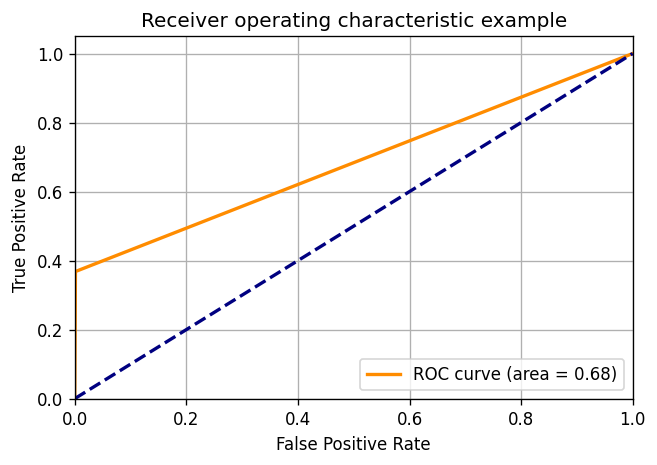

In [22]:
plt.figure(dpi = 120)
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid()
plt.show()